# Tobacco trial classification
In this notebook we will try to classify 13M~ documents into 10 classes. 

The data is available in two different ways :
    - Textual data 
    - Images of the documents
    

### Necessary import (Make sure you can run this before running the script )

In [98]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from keras.layers import Dropout
from keras.preprocessing.text import text_to_word_sequence
from keras.utils import to_categorical
from keras.layers import Input, Dense,Activation,Convolution1D,Flatten,MaxPooling1D,Conv1D,LSTM,Dropout, Embedding
from keras.models import Model, Sequential
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [81]:
def confusion_matrix_NN(NN,x_test,y_test) :
        y_pred = NN.predict(np.array(x_test))
        y_test_class = np.argmax(y_test,axis=1)
        y_pred_class = np.argmax(y_pred,axis=1)
        cf = confusion_matrix(y_test_class,y_pred_class)
        print(cf)

#### Opening metadata

In [2]:
meta_data = pd.read_csv("data/Tobacco3482.csv")

# Here I'm extracting the label
labels = np.unique(meta_data["label"])

#### Opening data

In [108]:
x = []
y = []
label_classes = {}
i = 0
for l in labels :
    path = 'data/'+l+"/*.txt"
    print("Opening "+ l +" data")
    files=glob.glob(path)   
    for file in files:
        f=open(file, 'r')  
        x.append(f.read())
        y.append(l)
        f.close()
    label_classes[i] = l
    i+=1
print("Opened "+str(len(x))+" documents, "+str(len(np.unique(y)))+" different classes" )

Opening Advertisement data
Opening Email data
Opening Form data
Opening Letter data
Opening Memo data
Opening News data
Opening Note data
Opening Report data
Opening Resume data
Opening Scientific data
Opened 3482 documents, 10 different classes


# Statistical analysis of the data

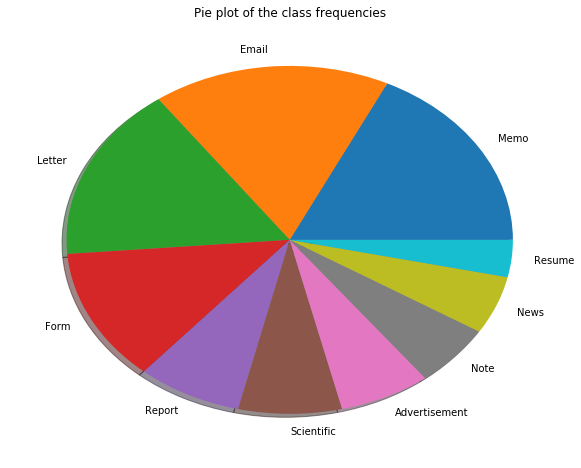

In [4]:
counts =meta_data["label"].value_counts()
plt.figure(1,figsize = (10,8))
plt.title("Pie plot of the class frequencies")
plt.pie(counts,labels = counts.index,shadow = True)
plt.show()

We can see that the classes are not very unbalanced even though 3 classes form half the data but given that they are Letter, Email and Memo, it's a normal behaviour given how the data were acquired

#### Pre-treatment of the data 

##### Tokenizing

Here we choose to tokenize the data in order to establish a baseline with a naive Bayes model.

In [93]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
y = le.fit_transform(y)

x_train,x_test,y_train,y_test = train_test_split(x,y, test_size=0.1 , random_state = 42)

In [94]:
sentences = [text_to_word_sequence(s) for s in x]

vectorizer = CountVectorizer()
vectorizer.fit(x_train)

x_train_counts = vectorizer.transform(x_train)
x_test_counts = vectorizer.transform(x_test)

x_train_tfidf= TfidfTransformer().fit_transform(x_train_counts)
x_test_tfidf= TfidfTransformer().fit_transform(x_test_counts)


In [112]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(x_train_tfidf,y_train)
print("Accuracy score : ")
print(clf.score(x_test_tfidf,y_test))
y_pred = clf.predict(x_test_tfidf)
print("Confusion matrix :")
print(confusion_matrix(y_pred,y_test))
print("Classification report :")
print(classification_report(y_pred,y_test))
print("Where classes are :")
for l in label_classes :
    print(str(l)+" : "+label_classes[l])

Accuracy score : 
0.48424068767908307
Confusion matrix :
[[ 4  0  0  0  0  0  0  0  0  0]
 [ 1 58  0  0  0  1  1  0  0  0]
 [ 4  0 17  0  0  3  5  0  0  1]
 [ 8  2  7 40  3  9  4  6  7 15]
 [16  6 24 20 47  2 10 12  0 13]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  2  0]
 [ 0  0  0  0  0  0  0  0  0  1]]
Classification report :
             precision    recall  f1-score   support

          0       0.12      1.00      0.22         4
          1       0.88      0.95      0.91        61
          2       0.35      0.57      0.44        30
          3       0.67      0.40      0.50       101
          4       0.94      0.31      0.47       150
          5       0.00      0.00      0.00         0
          6       0.00      0.00      0.00         0
          7       0.00      0.00      0.00         0
          8       0.22      1.00      0.36         2
          9       0.03      1.00      0.06         1

avg

/home/robin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


# Neural network part

# tfidf into neural network part

In [73]:
# Neural Network for tfidf or word2vec
def model_creation(dim_data): 
    dim = dim_data

    NN1 = Sequential()
    LSTM(10,input_shape=(None,dim))
    NN1.add(Dropout(0.5))
    
    NN1.add(Dense(50,activation="relu"))
    NN1.add(Dropout(0.5))

    NN1.add(Dense(10, activation='softmax'))

    NN1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return NN1

In [74]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
y = le.fit_transform(y)

x_train,x_test,y_train,y_test = train_test_split(x,y, test_size=0.1 , random_state = 42)

In [75]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=1, save_best_only=True)
callbacks=[checkpointer]

NN = model_creation(75956)
hist = NN.fit(x_train_tfidf.toarray(),to_categorical(y_train),epochs=200,validation_split=0.1,batch_size = 512,callbacks=[checkpointer])
NN.load_weights('weights.hdf5')

Train on 2819 samples, validate on 314 samples
Epoch 1/200
2819/2819 [==============================] - 4s 1ms/step - loss: 2.2938 - acc: 0.2302 - val_loss: 2.2726 - val_acc: 0.4459

Epoch 00001: val_loss improved from inf to 2.27261, saving model to weights.hdf5
Epoch 2/200
2819/2819 [==============================] - 2s 705us/step - loss: 2.2497 - acc: 0.4303 - val_loss: 2.2265 - val_acc: 0.4713

Epoch 00002: val_loss improved from 2.27261 to 2.22650, saving model to weights.hdf5
Epoch 3/200
2819/2819 [==============================] - 2s 709us/step - loss: 2.1880 - acc: 0.5140 - val_loss: 2.1744 - val_acc: 0.4809

Epoch 00003: val_loss improved from 2.22650 to 2.17444, saving model to weights.hdf5
Epoch 4/200
2819/2819 [==============================] - 2s 695us/step - loss: 2.1171 - acc: 0.5562 - val_loss: 2.1192 - val_acc: 0.5032

Epoch 00004: val_loss improved from 2.17444 to 2.11924, saving model to weights.hdf5
Epoch 5/200
2819/2819 [==============================] - 2s 680us/s


Epoch 00037: val_loss improved from 0.94331 to 0.93008, saving model to weights.hdf5
Epoch 38/200
2819/2819 [==============================] - 2s 708us/step - loss: 0.4058 - acc: 0.9546 - val_loss: 0.9171 - val_acc: 0.7484

Epoch 00038: val_loss improved from 0.93008 to 0.91715, saving model to weights.hdf5
Epoch 39/200
2819/2819 [==============================] - 2s 694us/step - loss: 0.3790 - acc: 0.9546 - val_loss: 0.9054 - val_acc: 0.7484

Epoch 00039: val_loss improved from 0.91715 to 0.90544, saving model to weights.hdf5
Epoch 40/200
2819/2819 [==============================] - 2s 697us/step - loss: 0.3628 - acc: 0.9585 - val_loss: 0.8949 - val_acc: 0.7516

Epoch 00040: val_loss improved from 0.90544 to 0.89492, saving model to weights.hdf5
Epoch 41/200
2819/2819 [==============================] - 2s 685us/step - loss: 0.3439 - acc: 0.9613 - val_loss: 0.8842 - val_acc: 0.7580

Epoch 00041: val_loss improved from 0.89492 to 0.88424, saving model to weights.hdf5
Epoch 42/200
2819/

2819/2819 [==============================] - 2s 726us/step - loss: 0.1468 - acc: 0.9865 - val_loss: 0.7052 - val_acc: 0.7930

Epoch 00074: val_loss improved from 0.70827 to 0.70522, saving model to weights.hdf5
Epoch 75/200
2819/2819 [==============================] - 2s 702us/step - loss: 0.1426 - acc: 0.9833 - val_loss: 0.7031 - val_acc: 0.7898

Epoch 00075: val_loss improved from 0.70522 to 0.70315, saving model to weights.hdf5
Epoch 76/200
2819/2819 [==============================] - 2s 711us/step - loss: 0.1352 - acc: 0.9869 - val_loss: 0.7004 - val_acc: 0.7930

Epoch 00076: val_loss improved from 0.70315 to 0.70041, saving model to weights.hdf5
Epoch 77/200
2819/2819 [==============================] - 2s 727us/step - loss: 0.1310 - acc: 0.9851 - val_loss: 0.6975 - val_acc: 0.7994

Epoch 00077: val_loss improved from 0.70041 to 0.69750, saving model to weights.hdf5
Epoch 78/200
2819/2819 [==============================] - 2s 711us/step - loss: 0.1288 - acc: 0.9869 - val_loss: 0.69

2819/2819 [==============================] - 2s 703us/step - loss: 0.0819 - acc: 0.9918 - val_loss: 0.6380 - val_acc: 0.7994

Epoch 00111: val_loss improved from 0.63916 to 0.63802, saving model to weights.hdf5
Epoch 112/200
2819/2819 [==============================] - 2s 721us/step - loss: 0.0753 - acc: 0.9915 - val_loss: 0.6370 - val_acc: 0.7994

Epoch 00112: val_loss improved from 0.63802 to 0.63699, saving model to weights.hdf5
Epoch 113/200
2819/2819 [==============================] - 2s 706us/step - loss: 0.0784 - acc: 0.9926 - val_loss: 0.6361 - val_acc: 0.7994

Epoch 00113: val_loss improved from 0.63699 to 0.63606, saving model to weights.hdf5
Epoch 114/200
2819/2819 [==============================] - 2s 774us/step - loss: 0.0763 - acc: 0.9929 - val_loss: 0.6354 - val_acc: 0.7994

Epoch 00114: val_loss improved from 0.63606 to 0.63537, saving model to weights.hdf5
Epoch 115/200
2819/2819 [==============================] - 2s 767us/step - loss: 0.0718 - acc: 0.9936 - val_loss: 

2819/2819 [==============================] - 2s 727us/step - loss: 0.0517 - acc: 0.9947 - val_loss: 0.6173 - val_acc: 0.8153

Epoch 00149: val_loss did not improve from 0.61288
Epoch 150/200
2819/2819 [==============================] - 2s 712us/step - loss: 0.0523 - acc: 0.9929 - val_loss: 0.6178 - val_acc: 0.8057

Epoch 00150: val_loss did not improve from 0.61288
Epoch 151/200
2819/2819 [==============================] - 2s 713us/step - loss: 0.0493 - acc: 0.9954 - val_loss: 0.6167 - val_acc: 0.8057

Epoch 00151: val_loss did not improve from 0.61288
Epoch 152/200
2819/2819 [==============================] - 2s 699us/step - loss: 0.0547 - acc: 0.9901 - val_loss: 0.6157 - val_acc: 0.8057

Epoch 00152: val_loss did not improve from 0.61288
Epoch 153/200
2819/2819 [==============================] - 2s 737us/step - loss: 0.0520 - acc: 0.9933 - val_loss: 0.6150 - val_acc: 0.8089

Epoch 00153: val_loss did not improve from 0.61288
Epoch 154/200
2819/2819 [==============================] - 

2819/2819 [==============================] - 2s 703us/step - loss: 0.0395 - acc: 0.9961 - val_loss: 0.6046 - val_acc: 0.8121

Epoch 00189: val_loss did not improve from 0.60375
Epoch 190/200
2819/2819 [==============================] - 2s 684us/step - loss: 0.0376 - acc: 0.9957 - val_loss: 0.6047 - val_acc: 0.8121

Epoch 00190: val_loss did not improve from 0.60375
Epoch 191/200
2819/2819 [==============================] - 2s 692us/step - loss: 0.0451 - acc: 0.9943 - val_loss: 0.6044 - val_acc: 0.8121

Epoch 00191: val_loss did not improve from 0.60375
Epoch 192/200
2819/2819 [==============================] - 2s 693us/step - loss: 0.0390 - acc: 0.9947 - val_loss: 0.6039 - val_acc: 0.8121

Epoch 00192: val_loss did not improve from 0.60375
Epoch 193/200
2819/2819 [==============================] - 2s 698us/step - loss: 0.0418 - acc: 0.9936 - val_loss: 0.6042 - val_acc: 0.8121

Epoch 00193: val_loss did not improve from 0.60375
Epoch 194/200
2819/2819 [==============================] - 

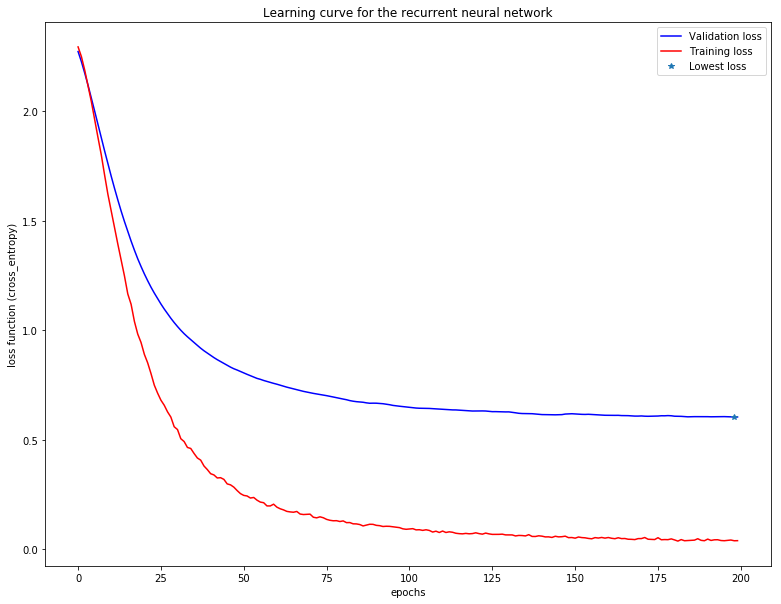

In [97]:
plt.figure("Learning curve",figsize=(13,10))
plt.plot(hist.history["val_loss"],"b")
plt.plot(hist.history["loss"],"r")
plt.plot(np.argmin(hist.history["val_loss"]),hist.history["val_loss"][np.argmin(hist.history["val_loss"])],"*")
plt.legend(("Validation loss","Training loss","Lowest loss"))
plt.title("Learning curve for the recurrent neural network")
plt.ylabel("loss function (cross_entropy)")
plt.xlabel("epochs")
plt.show()

# Conclusion and comparaison 

In the previous part, we compared two neural approaches. One is based on the tfidf transformation and the other one is based on tokenizing the sentences and then train an embedding on those tokens. We can observe that the tokenizing stategy converges faster but also takes more time to train and predict data. Those two approaches are viable but the choice will depend on the application where the model will be used.

In [111]:
print("Accuracy score :")
print(NN.evaluate(x_test_tfidf.toarray(),to_categorical(y_test))[1])

print("Confusion matrix :")
confusion_matrix_NN(NN,x_test_tfidf.toarray(),to_categorical(y_test))

print("Classification report :")
y_pred = NN.predict(np.array(x_test_tfidf.toarray()))
y_test_class = np.argmax(to_categorical(y_test),axis=1)
y_pred_class = np.argmax(y_pred,axis=1)
print(classification_report(y_pred_class,y_test_class))

print("Where classes are :")
for l in label_classes :
    print(str(l)+" : "+label_classes[l])

Accuracy score :
349/349 [==============================] - 0s 422us/step
0.8137535808079563
Confusion matrix :
[[25  0  3  1  0  0  3  1  0  0]
 [ 0 64  0  0  2  0  0  0  0  0]
 [ 2  0 37  2  3  0  2  1  0  1]
 [ 0  0  2 47  9  0  0  2  0  0]
 [ 0  0  0  1 48  0  1  0  0  0]
 [ 0  0  4  0  0 11  0  0  0  0]
 [ 2  0  2  1  2  0 13  0  0  0]
 [ 0  0  1  4  0  0  0 11  0  2]
 [ 0  0  0  0  0  0  0  0  9  0]
 [ 1  0  1  0  3  2  0  3  1 19]]
Classification report :
             precision    recall  f1-score   support

          0       0.76      0.83      0.79        30
          1       0.97      1.00      0.98        64
          2       0.77      0.74      0.76        50
          3       0.78      0.84      0.81        56
          4       0.96      0.72      0.82        67
          5       0.73      0.85      0.79        13
          6       0.65      0.68      0.67        19
          7       0.61      0.61      0.61        18
          8       1.00      0.90      0.95        10
  